# Featuretools Solution for Predicting Covid Global Forcast
<p><c>
    <img src="images/corona.png" alt="corona" width=200/>
</c></p>

글로벌 코로나 바이러스의 누적 확잔수와 사망자수의 예측 문제를 featuretools를 이용해서 풀어보기로 한다. 

원래는 featuretools는 기 정규화된 관계형 테이블을 입력으로 바로 작업이 가능하지만, featuretools의 entity set 생성 기능을 예시로 보이기 위해 역졍규화를 한 데이터를 입력으로 준비한다.

In [1]:
import pandas as pd
import numpy as np
import featuretools as ft
from collections import defaultdict
from sklearn.metrics import roc_auc_score
from featuretools.primitives import Count, Mean
import os
import utils
%matplotlib inline

# 역정규화 데이터 준비

In [2]:
data = pd.read_csv('data/train.csv', parse_dates=['Date'], encoding='utf-8')
data.rename(columns={'Date': 'date', 
                     'Province/State':'state', 'Lat': 'lat', 'Long': 'long',
                     'Country/Region':'country',
                     'ConfirmedCases': 'confirmed',
                     'Fatalities':'deaths'
                    }, inplace=True)


# 나라 통계 정보와 결합 
countries_df = utils.get_country_df()
data = pd.merge(data, countries_df, on='country')

# Weather 정보와 결합
weather_df = utils.get_weather_df()
data = data.merge(weather_df, on=['country','date', 'state'], how='inner')

# 천명당 병상수 정보와 결합 
icu_df = utils.get_icu_df()
data = pd.merge(data, icu_df, on='country')
# feature 정리
def make_feature(data):     
    train_data = data.copy()
    threshold = 0.00001
    train_data['infectionRate'] = round((train_data['confirmed']/train_data['population'])*100, 5)
    train_data = train_data[train_data['infectionRate'] >= threshold]
    train_data = train_data.drop(["infectionRate","state","date","index"], axis= 1).dropna()
    train_data.rename(columns={'Id': 'record_id'}, inplace=True)
    
    return train_data

data = make_feature(data)
data[data['country']=='China'].head(5)

,record_id,country,lat,long,confirmed,deaths,population,density,fertility,age,urban_percentage,humidity,sunHour,tempC,windspeedKmph,icu
1206,4378,China,31.8257,117.2264,106.0,0.0,1439323776,153,1.7,38.0,0.61,54.0,5.4,5.0,3.0,4.2
1207,4379,China,31.8257,117.2264,152.0,0.0,1439323776,153,1.7,38.0,0.61,49.0,8.7,7.0,2.0,4.2
1208,4380,China,31.8257,117.2264,200.0,0.0,1439323776,153,1.7,38.0,0.61,45.0,8.7,10.0,2.0,4.2
1209,4381,China,31.8257,117.2264,237.0,0.0,1439323776,153,1.7,38.0,0.61,37.0,8.7,11.0,8.0,4.2
1210,4382,China,31.8257,117.2264,297.0,0.0,1439323776,153,1.7,38.0,0.61,23.0,7.1,4.0,9.0,4.2


# entity set 만들기

### variable type 정의

In [3]:
import featuretools.variable_types as vtypes
variable_types = {'country': vtypes.Categorical,
                  'lat': vtypes.Numeric,
                  'long': vtypes.Numeric,
                  'confirmed': vtypes.Numeric,
                  'deaths': vtypes.Numeric,
                  'population': vtypes.Numeric,
                  'density': vtypes.Numeric,
                  'fertility': vtypes.Numeric,
                  'age': vtypes.Ordinal,
                  'urban_percentage': vtypes.Numeric,
                  'humidity': vtypes.Numeric,
                  'sunHour': vtypes.Numeric,
                  'tempC': vtypes.Numeric,
                  'windspeedKmph': vtypes.Numeric,
                  'icu': vtypes.Numeric}

### entity set 정의

In [4]:
# Make an entity named 'covid-19' which stores dataset metadata with the dataframe
es = ft.EntitySet('covid-19')
es = es.entity_from_dataframe(
    entity_id="records",
    dataframe=data,
    index='record_id',
    #time_index=...,
    variable_types=variable_types)

es.normalize_entity(
    base_entity_id="records",
    new_entity_id="countries",
    index="country",
    make_time_index=False,
    additional_variables=['population', 'density', 'fertility', 'age', 'urban_percentage', 'lat', 'long'])

es.normalize_entity(
    base_entity_id="records",
    new_entity_id="weathers",
    index="country",
    make_time_index=False,
    additional_variables=['humidity', 'sunHour', 'tempC', 'windspeedKmph'])

es.normalize_entity(
    base_entity_id="records",
    new_entity_id="beds",
    index="country",
    make_time_index=False,
    additional_variables=['icu'])

Entityset: covid-19
  Entities:
    records [Rows: 2299, Columns: 4]
    countries [Rows: 8, Columns: 8]
    weathers [Rows: 8, Columns: 5]
    beds [Rows: 8, Columns: 2]
  Relationships:
    records.country -> countries.country
    records.country -> weathers.country
    records.country -> beds.country

# Visualize entity set

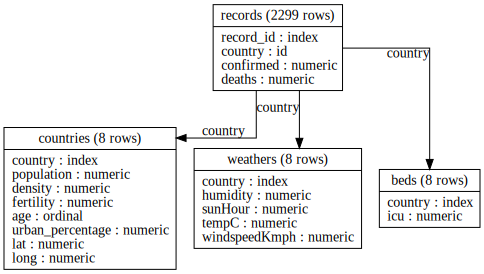

In [5]:
es.plot()

# Generating Features with Deep Feature Synthesis

In [6]:
# Generate features using the constructed entityset
fm, features = ft.dfs(entityset=es,
                      target_entity='records',
                      #agg_primitives=['count', 'percent_true'],
                      #trans_primitives=['is_weekend', 'weekday', 'day', 'month', 'year'],
                      max_depth=3,
                      #approximate='6h',
                      #cutoff_time=cutoff_times[20000:],
                      verbose=True)

Built 54 features
Elapsed: 00:00 | Progress: 100%|██████████


In [7]:
features[-10:]   # records쪽은 label빼고는 쓸 만한 feature가 없어서 난감 ㅠㅠ 

[<Feature: beds.STD(records.deaths)>,
 <Feature: beds.MAX(records.confirmed)>,
 <Feature: beds.MAX(records.deaths)>,
 <Feature: beds.SKEW(records.confirmed)>,
 <Feature: beds.SKEW(records.deaths)>,
 <Feature: beds.MIN(records.confirmed)>,
 <Feature: beds.MIN(records.deaths)>,
 <Feature: beds.MEAN(records.confirmed)>,
 <Feature: beds.MEAN(records.deaths)>,
 <Feature: beds.COUNT(records)>]

## 억지스럽지만 deaths를 feature로, confirmed를 label로 하는 정도로 학습해 보자

In [8]:
selected_columns = [column for column in fm.columns if 'confirmed' not in column and column != 'country']

y = fm[["confirmed"]]
X = fm[selected_columns]
X.columns

Index(['deaths', 'countries.population', 'countries.density',
       'countries.fertility', 'countries.age', 'countries.urban_percentage',
       'countries.lat', 'countries.long', 'weathers.humidity',
       'weathers.sunHour', 'weathers.tempC', 'weathers.windspeedKmph',
       'beds.icu', 'countries.SUM(records.deaths)',
       'countries.STD(records.deaths)', 'countries.MAX(records.deaths)',
       'countries.SKEW(records.deaths)', 'countries.MIN(records.deaths)',
       'countries.MEAN(records.deaths)', 'countries.COUNT(records)',
       'weathers.SUM(records.deaths)', 'weathers.STD(records.deaths)',
       'weathers.MAX(records.deaths)', 'weathers.SKEW(records.deaths)',
       'weathers.MIN(records.deaths)', 'weathers.MEAN(records.deaths)',
       'weathers.COUNT(records)', 'beds.SUM(records.deaths)',
       'beds.STD(records.deaths)', 'beds.MAX(records.deaths)',
       'beds.SKEW(records.deaths)', 'beds.MIN(records.deaths)',
       'beds.MEAN(records.deaths)', 'beds.COUNT(records

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error, make_scorer

# 평가 척도 함수 정의
def rmsle(y_true, y_pred):
    """
    Computes the Root Mean Squared Logarithmic Error of a prediction set.
    params:
        y_true: numpy array of ground truth
        y_pred: numpy array of predictions
    """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
rmsle_scorer = make_scorer(rmsle)

# Split into training and evaluation data:
X_train, X_val, y_train, y_val = tts(X, y, test_size= 0.2, random_state=42, shuffle=True)


# 확진자수 예측 모델 학습/평가
model_infected = DecisionTreeRegressor(random_state=42, criterion="mae")
scores = cross_val_score(model_infected, X_train,y_train["confirmed"], cv=5, scoring=rmsle_scorer)

print("Cross Validation of Confirmed Cases: Mean = {}, std = {}".format(scores.mean(), scores.std()))
model_infected.fit(X_train, y_train["confirmed"])
result_infected = rmsle(y_val["confirmed"], model_infected.predict(X_val))
print("Validation Infected set RMSLE: {}".format(result_infected))


Cross Validation of Confirmed Cases: Mean = 0.8747742987448761, std = 0.036354425838695345
Validation Infected set RMSLE: 0.8768648281578775


# 주요 feature 도식화 

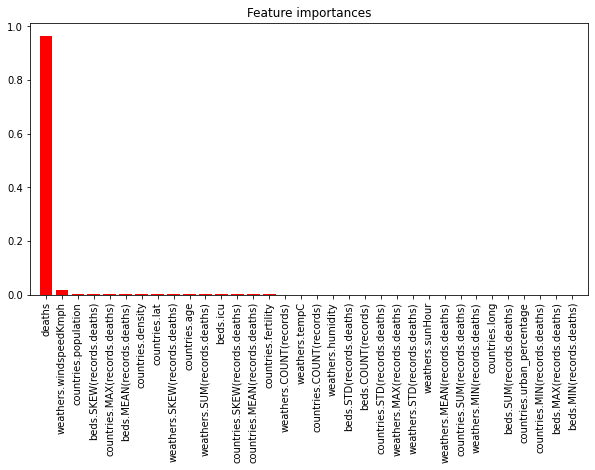

In [10]:
utils.show_feature_importance(X_train,model_infected)